# Examining vaccination rates

The [Western Pennsylvania Regional Data Center](https://www.wprdc.org) collects, timestamps, and archives Pennsylvania's [public vaccination data](https://data.pa.gov/browse?q=vaccinations) as it updates. These [archived datasets](https://data.wprdc.org/dataset/weekly-pennsylvania-covid-19-vaccinations-stats-archive) allow for examination of vaccination rates over time.

## Zip code

### Get the data

In [67]:
import pandas
import pandas as pd

vac_race_zip_csv = "https://data.wprdc.org/datastore/dump/d3f5c6a6-c5f8-48db-8da2-f22a39bc8ef8"


def n2z(x) -> float:
    return float(0) if not x else float(x)


# converts null to 0 on the data fields
converters = {k: n2z for k in range(2, 16)}

df = pandas.read_csv(
    vac_race_zip_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
    dtype={'patient_zip_code': str}
)
df.head()

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,date_saved
0,17142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
1,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
2,19424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2021-07-27
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,2021-07-27
4,15426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27


### Mix-in demographic data

In [68]:
# Get zip_code demographic data and prepare to merge with vaccine data
demog_data_file = 'https://raw.githubusercontent.com/WPRDC/bec-vaccination-map/main/zip_code_pop_2019.csv'

source_demog_df = pd.read_csv(demog_data_file, dtype={'zip code tabulation area': str})

total_pop = source_demog_df['B01001_001E']
black_pop = source_demog_df['B01001B_001E']

# < 10 years populations
total_kid_pop = (source_demog_df['B01001_003E'] + source_demog_df['B01001_004E'] + source_demog_df['B01001_027E'] +          source_demog_df['B01001_028E'])

black_kid_pop = (source_demog_df['B01001B_003E'] + source_demog_df['B01001B_004E'] + source_demog_df['B01001B_018E'] +             source_demog_df['B01001B_019E'])

eligible_pop = total_pop - total_kid_pop.multiply(1.2)
eligible_black_pop = black_pop - black_kid_pop.multiply(1.2)

demog_df = pd.DataFrame({
    'zip_code': source_demog_df['zip code tabulation area'],
    'eligible_pop': eligible_pop,
    'eligible_black_pop': eligible_black_pop,
})
demog_df.head()

,zip_code,eligible_pop,eligible_black_pop
0,15320,4545.6,0.0
1,15321,1363.8,0.0
2,15325,322.2,0.0
3,15334,107.4,0.0
4,15348,213.0,0.0


In [69]:
# Join datasets
race_strings = ['african_american', 'asian', 'multiple_other', 'native_american', 'pacific_islander', 'white', 'unknown']

# join the demographic data with the vax data
full_df = pd.merge(df, demog_df, left_on='patient_zip_code', right_on='zip_code')

# get total vaccine numbers
full_df['fully_covered_total'] = sum([full_df[f'fully_covered_{race_str}'] for race_str in race_strings])
full_df['total_percent_fully_covered'] = full_df['fully_covered_total'] / full_df['eligible_pop']
full_df['black_percent_fully_covered'] = full_df['fully_covered_african_american'] / full_df['eligible_black_pop']

full_df.head()

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,...,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,date_saved,zip_code,eligible_pop,eligible_black_pop,fully_covered_total,total_percent_fully_covered,black_percent_fully_covered
0,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,0.0,2021-07-27,15448,284.8,0.0,38.0,0.133427,NaN
1,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,0.0,2021-08-02,15448,284.8,0.0,38.0,0.133427,NaN
2,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,0.0,2021-08-09,15448,284.8,0.0,38.0,0.133427,NaN
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,0.0,2021-08-16,15448,284.8,0.0,38.0,0.133427,NaN
4,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,38.0,0.0,2021-08-23,15448,284.8,0.0,38.0,0.133427,NaN


### Percent of eligible Black residents who are fully vaccinated per zip code
For zip codes `15104`, `15132`, `15206`, `15208`, `15210`, `15212`, `15214`, `15219`, `15221`, `15235`

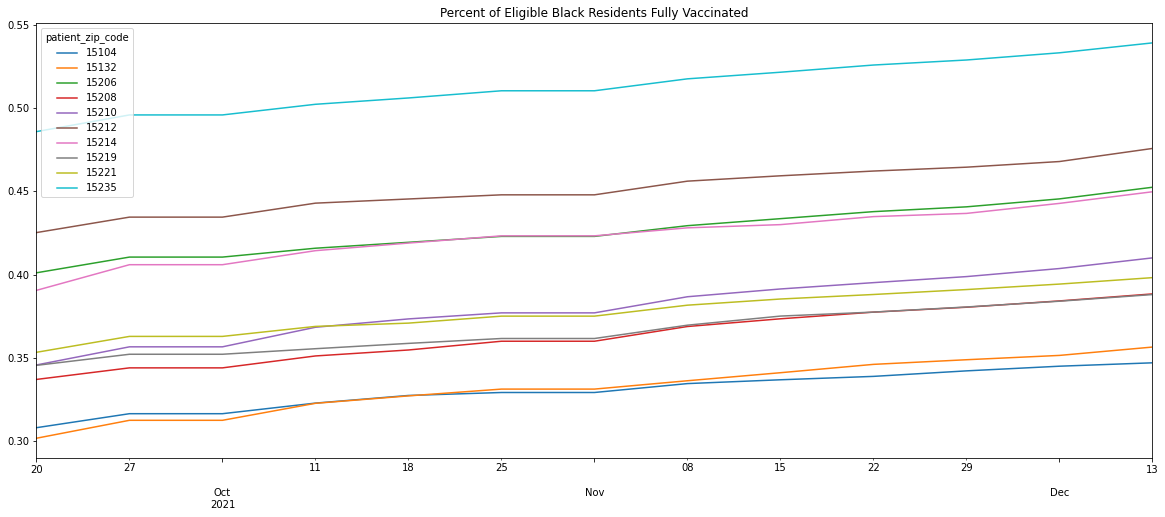

In [70]:
# Limit the dataset to the past month and select zipcodes
from datetime import datetime, timedelta, date

# start date being 30 days before today
start = datetime.now() - timedelta(days=90)

# filter for zipcodes that start '15'
local_zipcodes = lambda z: z[:2] == '15'

# filter zipcodes in Allegheny County with large proportion Black population
ac_black_zipcodes = ['15104', '15132', '15206', '15208', '15210', '15212', '15214', '15219', '15221', '15235', ]
full_df = full_df[(full_df['zip_code'].isin(ac_black_zipcodes)) & (full_df['date_saved'] > start)]

by_date_zip_pivot = full_df.pivot(index='date_saved', columns='patient_zip_code', values='black_percent_fully_covered')
rate_plot = by_date_zip_pivot.plot(
    title='Percent of Eligible Black Residents Fully Vaccinated',
    xlabel='',
    figsize=(20, 8),
)

## Allegheny County
### Get the data

In [71]:
# get county data for comparison
county_by_race_csv = 'https://data.wprdc.org/datastore/dump/a6f52fb9-6c3a-40e4-adc4-2bd806b165fd'

county_df = pd.read_csv(
    county_by_race_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
)
race_strings = ['african_american', 'asian', 'multiple_other', 'native_american', 'pacific_islander', 'white', 'unknown']

# calculate
county_df['fully_covered_total'] = sum([county_df[f'fully_covered_{race_str}'] for race_str in race_strings])
county_df['partially_covered_total'] = sum([county_df[f'partially_covered_{race_str}'] for race_str in race_strings])

# limit to allegheny county
county_df = county_df[(county_df['county_name'].str.upper() == 'ALLEGHENY')]
county_df.sort_index(ascending=False)


,date_saved,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,fully_covered_total,partially_covered_total
2552,2021-12-13,ALLEGHENY,12095.0,5079.0,289.0,193.0,17457.0,76926.0,10653.0,60141.0,13751.0,654.0,2396.0,97656.0,528835.0,64649.0,768082.0,122692.0
2467,2021-12-06,ALLEGHENY,11323.0,4654.0,272.0,198.0,16954.0,76486.0,10283.0,59313.0,13104.0,626.0,2390.0,95361.0,521067.0,64868.0,756729.0,120170.0
2417,2021-11-29,ALLEGHENY,10741.0,4374.0,249.0,199.0,16037.0,74389.0,9950.0,58713.0,12689.0,614.0,2385.0,93825.0,516021.0,64952.0,749199.0,115939.0
2355,2021-11-22,ALLEGHENY,9849.0,3383.0,207.0,195.0,14440.0,65361.0,9393.0,58354.0,12424.0,607.0,2382.0,92434.0,514595.0,65252.0,746048.0,102828.0
2302,2021-11-15,ALLEGHENY,9239.0,2789.0,188.0,184.0,13352.0,56677.0,8708.0,57818.0,12178.0,593.0,2389.0,90162.0,512714.0,65684.0,741538.0,91137.0
2211,2021-11-08,ALLEGHENY,8740.0,2254.0,169.0,175.0,11332.0,48035.0,8894.0,57196.0,11914.0,578.0,2390.0,87819.0,510601.0,66951.0,737449.0,79599.0
2133,2021-11-01,ALLEGHENY,8489.0,2077.0,161.0,173.0,10245.0,45480.0,8292.0,56835.0,11690.0,567.0,2390.0,85868.0,509176.0,68553.0,735079.0,74917.0
2075,2021-10-25,ALLEGHENY,8892.0,2055.0,163.0,183.0,9919.0,47405.0,9046.0,56246.0,11492.0,558.0,2402.0,83392.0,508460.0,68983.0,731533.0,77663.0
1994,2021-10-18,ALLEGHENY,8678.0,1912.0,157.0,185.0,9220.0,45423.0,8842.0,55733.0,11245.0,547.0,2412.0,79896.0,508477.0,69708.0,728018.0,74417.0
1954,2021-10-11,ALLEGHENY,8548.0,1883.0,154.0,185.0,8426.0,44293.0,8859.0,55206.0,11006.0,532.0,2416.0,75964.0,508522.0,70369.0,724015.0,72348.0


### Mix-in county-level demographic data

In [72]:
lt_5_auth_date = datetime.fromisoformat('2021-10-29')

county_demog_df = pd.read_csv('https://github.com/WPRDC/bec-vaccination-map/raw/main/notebooks/ac_demo.tsv', sep='\t')
ac_age_race_lookup = county_demog_df.to_dict('records')[0]
# Demographic data from from ACS 2019 (5yr agg)
county_total_pop = ac_age_race_lookup['B01001001']  # 1221744
county_black_pop = ac_age_race_lookup['B01001B001']  # 157060

total_pop_tables = {
    'total': ['B01001001', ],
    'african_american': ['B01001B001', ],
    'asian': ['B01001D001', ],
    'multiple_other': ['B01001F001', 'B01001G001'],
    'native_american': ['B01001C001', ],
    'pacific_islander': ['B01001E001', ],
    'white': ['B01001A001', ],
}

# make mapping of race category string to respective acs tables
lt_12_tables = {
    'total': ['B01001003', 'B01001004', 'B01001018', 'B01001019'],
    'african_american': ['B01001B003', 'B01001B004', 'B01001B018', 'B01001B019'],
    'asian': ['B01001D003', 'B01001D004', 'B01001D018', 'B01001D019'],
    'multiple_other': ['B01001F003', 'B01001F004', 'B01001F018', 'B01001F019',
                       'B01001G003', 'B01001G004', 'B01001G018', 'B01001G019'],
    'native_american': ['B01001C003', 'B01001C004', 'B01001C018', 'B01001C019'],
    'pacific_islander': ['B01001E003', 'B01001E004', 'B01001E018', 'B01001A019'],
    'white': ['B01001A003', 'B01001A004', 'B01001A018', 'B01001A019']
}

lt_5_tables = {
    'total': ['B01001003', 'B01001018', ],
    'african_american': ['B01001B003', 'B01001B018', ],
    'asian': ['B01001D003', 'B01001D018' ],
    'multiple_other': ['B01001F003', 'B01001F003', 'B01001G018'],
    'native_american': ['B01001C003', 'B01001C018', ],
    'pacific_islander': ['B01001E003', 'B01001E018', ],
    'white': ['B01001A003', 'B01001A018', ],
}

total_pops = {}
ac_lt_12_pop = {}
ac_lt_5_pop = {}
ac_old_eligible_pop = {}
ac_cur_eligible_pop = {}

county_df.set_index('date_saved')

,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,fully_covered_total,partially_covered_total
date_saved,,,,,,,,,,,,,,,,,
2021-03-25,Allegheny,11739.0,92.0,9.0,352.0,11284.0,131861.0,20396.0,8166.0,127.0,22.0,382.0,17303.0,111860.0,23389.0,161249.0,175733.0
2021-03-29,Allegheny,15603.0,174.0,18.0,443.0,11548.0,151477.0,23188.0,9377.0,159.0,24.0,465.0,21065.0,134728.0,24328.0,190146.0,202451.0
2021-04-05,Allegheny,16607.0,294.0,35.0,679.0,12193.0,158553.0,25208.0,11714.0,169.0,28.0,524.0,23382.0,165904.0,26417.0,228138.0,213569.0
2021-04-12,ALLEGHENY,16862.0,354.0,43.0,982.0,14264.0,160825.0,26524.0,13371.0,208.0,29.0,574.0,26258.0,188769.0,28332.0,257541.0,219854.0
2021-04-19,ALLEGHENY,18273.0,399.0,47.0,1099.0,14537.0,171361.0,26698.0,16695.0,263.0,34.0,696.0,29031.0,225933.0,33684.0,306336.0,232414.0
2021-04-26,ALLEGHENY,17777.0,301.0,37.0,1112.0,13145.0,170541.0,26200.0,21549.0,412.0,46.0,1070.0,37357.0,268989.0,39730.0,369153.0,229113.0
2021-05-10,ALLEGHENY,19049.0,200.0,29.0,753.0,12060.0,162120.0,33064.0,26878.0,592.0,67.0,1722.0,45915.0,335348.0,48961.0,459483.0,227275.0
2021-05-17,ALLEGHENY,18154.0,142.0,27.0,584.0,11219.0,146632.0,30041.0,29460.0,663.0,69.0,1945.0,47813.0,363201.0,53350.0,496501.0,206799.0
2021-05-24,ALLEGHENY,18046.0,132.0,27.0,522.0,11574.0,142976.0,28291.0,31624.0,698.0,70.0,2026.0,49592.0,383602.0,56742.0,524354.0,201568.0


In [73]:
import numpy as np
import pprint

# for each race category
for race_str in race_strings + ['total']:
    if race_str == 'unknown':
        continue

    total_pops[race_str] = sum([ac_age_race_lookup[table] for table in total_pop_tables[race_str]])
    ac_lt_12_pop[race_str] = sum([ac_age_race_lookup[table] for table in lt_12_tables[race_str]]) * 1.2
    ac_lt_5_pop[race_str] = sum([ac_age_race_lookup[table] for table in lt_5_tables[race_str]])

    # eligible populations before FDA auth for < 5 year olds
    ac_old_eligible_pop[race_str] = total_pops[race_str] - ac_lt_12_pop[race_str]

    # eligible populations on 2021-12-10
    ac_cur_eligible_pop[race_str] = total_pops[race_str] - ac_lt_5_pop[race_str]

    # calculate rates from before
    county_df[f'fully_covered_%_{race_str}_old'] = county_df[f'fully_covered_{race_str}'].divide(
        ac_old_eligible_pop[race_str])
    county_df[f'partially_covered_%_{race_str}_old'] = county_df[f'partially_covered_{race_str}'].divide(
        ac_old_eligible_pop[race_str])

    # calculate current rates
    county_df[f'fully_covered_%_{race_str}_cur'] = county_df[f'fully_covered_{race_str}'].divide(
        ac_cur_eligible_pop[race_str])
    county_df[f'partially_covered_%_{race_str}_cur'] = county_df[f'partially_covered_{race_str}'].divide(
        ac_cur_eligible_pop[race_str])

    # Join into one column based on date
    county_df[f'fully_covered_%_{race_str}_both'] = np.where(
        county_df.date_saved >= lt_5_auth_date,
        county_df[f'fully_covered_%_{race_str}_cur'] * 100,
        county_df[f'fully_covered_%_{race_str}_old'] * 100
    )
    county_df[f'partially_covered_%_{race_str}_both'] = np.where(
        county_df.date_saved >= lt_5_auth_date,
        county_df[f'partially_covered_%_{race_str}_cur'] * 100,
        county_df[f'partially_covered_%_{race_str}_old'] * 100
    )

total_pops

{'african_american': 157060,
 'asian': 45389,
 'multiple_other': 41393,
 'native_american': 1368,
 'pacific_islander': 362,
 'white': 976172,
 'total': 1221744}

## Current Rates in Allegheny County


In [74]:
ac_cur_eligible_pop

{'african_american': 146577,
 'asian': 42660,
 'multiple_other': 37683,
 'native_american': 1283,
 'pacific_islander': 362,
 'white': 931837,
 'total': 1171881}

In [75]:
for race_str in race_strings + ['total']:
    if race_str in ['unknown']:
        continue
county_df.sort_index(ascending=False).iloc[5]

date_saved                                   2021-11-08 00:00:00
county_name                                            ALLEGHENY
partially_covered_african_american                        8740.0
partially_covered_asian                                   2254.0
partially_covered_native_american                          169.0
partially_covered_pacific_islander                         175.0
partially_covered_multiple_other                         11332.0
partially_covered_white                                  48035.0
partially_covered_unknown                                 8894.0
fully_covered_african_american                           57196.0
fully_covered_asian                                      11914.0
fully_covered_native_american                              578.0
fully_covered_pacific_islander                            2390.0
fully_covered_multiple_other                             87819.0
fully_covered_white                                     510601.0
fully_covered_unknown    

In [80]:
column_strings_full = [f'fully_covered_%_{race_str}_both' for race_str in race_strings + ['total'] if
                       race_str not in ('unknown', 'native_american', 'pacific_islander', 'multiple_other')]

column_strings_partial = [f'partially_covered_%_{race_str}_both' for race_str in race_strings + ['total'] if
                          race_str not in ('unknown', 'native_american', 'pacific_islander', 'multiple_other')]

min_df = county_df[column_strings_full + ['date_saved']]
min_df.to_csv('out.csv')

(0.0, 70.14469294462495)

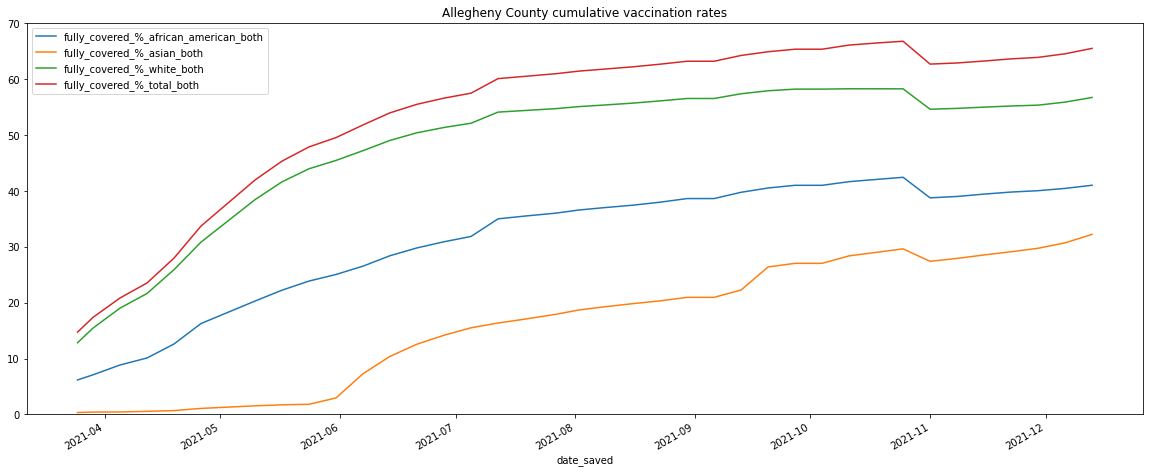

In [77]:
chart = county_df.plot(
    title='Allegheny County cumulative vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=column_strings_full
)

chart.set_ylim(bottom=0)

(0.0, 22.02746249115417)

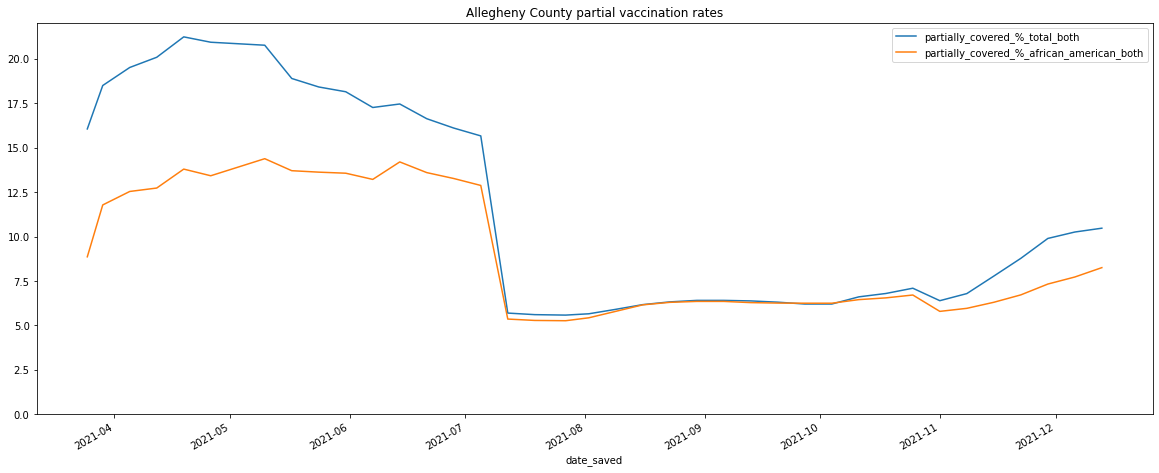

In [78]:
chart = county_df.plot(
    title='Allegheny County partial vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total_both', 'partially_covered_%_african_american_both']
)
chart.set_ylim(bottom=0)

<AxesSubplot:title={'center':'Allegheny County partial vaccination rates (past 90 days)'}, xlabel='date_saved'>

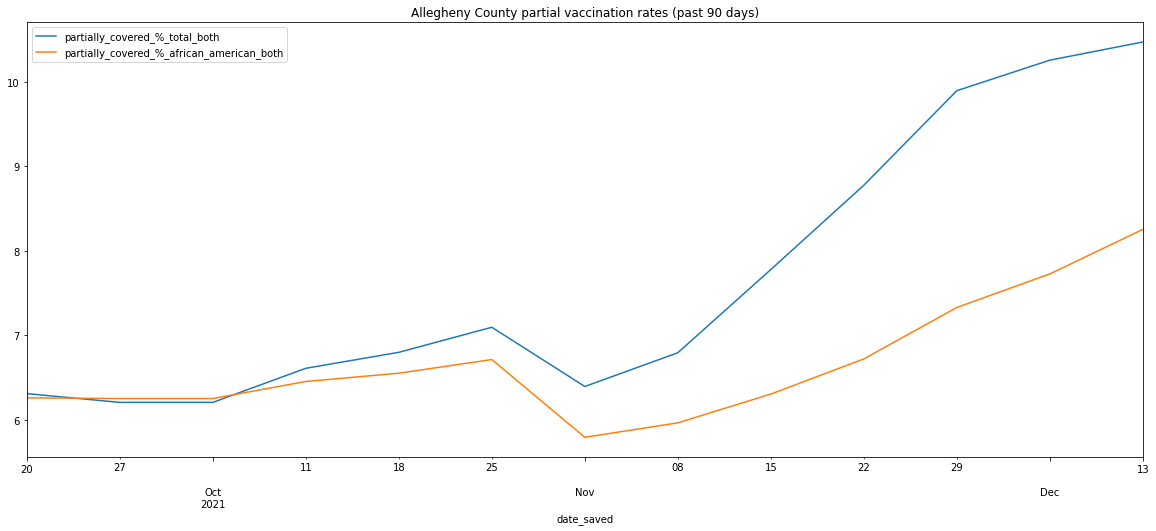

In [79]:
plot_start = datetime.now() - timedelta(days=90)
county_df[county_df['date_saved'] > plot_start].plot(
    title='Allegheny County partial vaccination rates (past 90 days)',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total_both', 'partially_covered_%_african_american_both'],
)